### Time Series and Forecasting

**Time Series**: A sequence of data points recorded at regular time intervals. Examples include daily stock prices or monthly sales figures. This data helps us understand how values change over time.

**Forecasting**: Using past data to predict future values. In time series forecasting, we analyze historical data to make informed predictions about future trends or patterns.


In [18]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [19]:
df = pd.read_csv('gold_monthly_csv.csv')
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [20]:
df.shape

(847, 2)

### Exploratory Data Analysis (EDA)

**Exploratory Data Analysis (EDA)**: A process of analyzing data sets to summarize their main characteristics, often using visual methods. EDA helps in understanding the data, uncovering patterns, spotting anomalies, and checking assumptions. It's a crucial step before applying any machine learning algorithms.


In [21]:
date = pd.date_range(start = '1/1/1950', end = '8/1/2020', freq = 'M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [22]:
df['Month'] = date
df.drop('Date', axis = 1, inplace = True)
df = df.set_index('Month')
df.head()


,Price
Month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


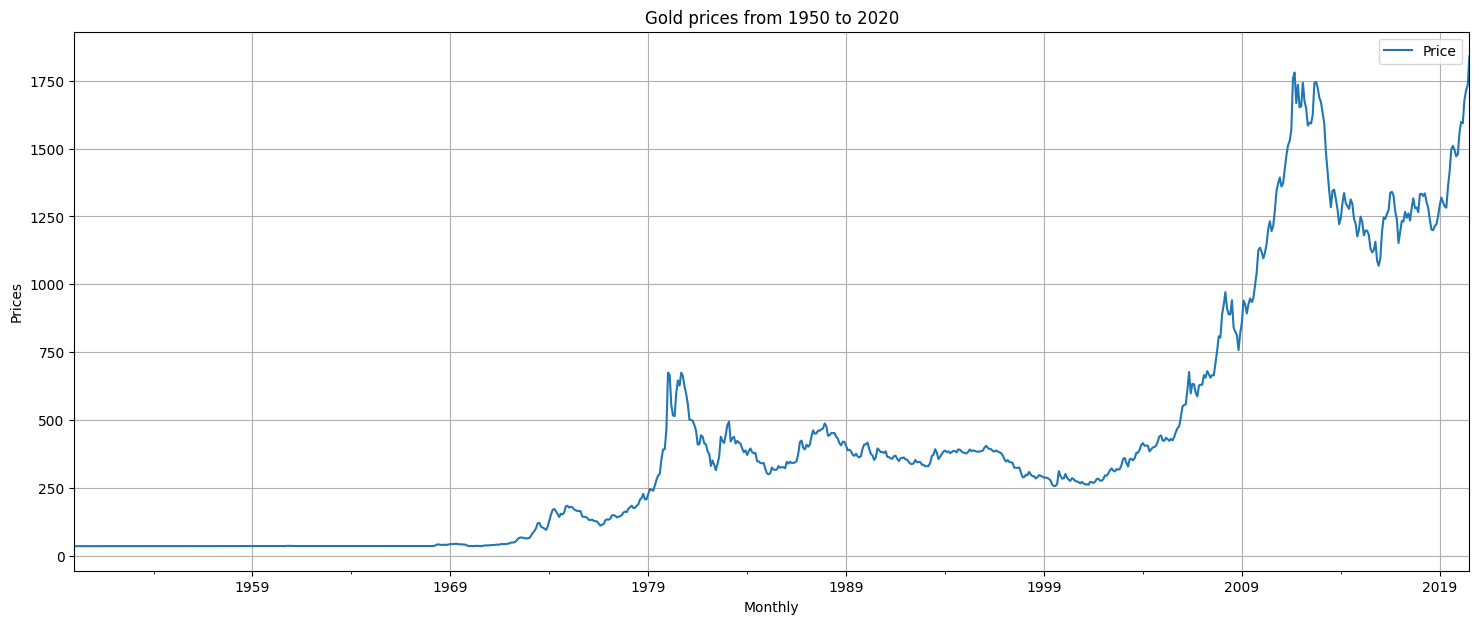

In [26]:
#Plotting Gold prices on Monthly basis
df.plot(figsize = (18, 7))
plt.title('Gold prices from 1950 to 2020')
plt.xlabel('Monthly')
plt.ylabel('Prices')
plt.grid()

In [27]:
round(df.describe(), 3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


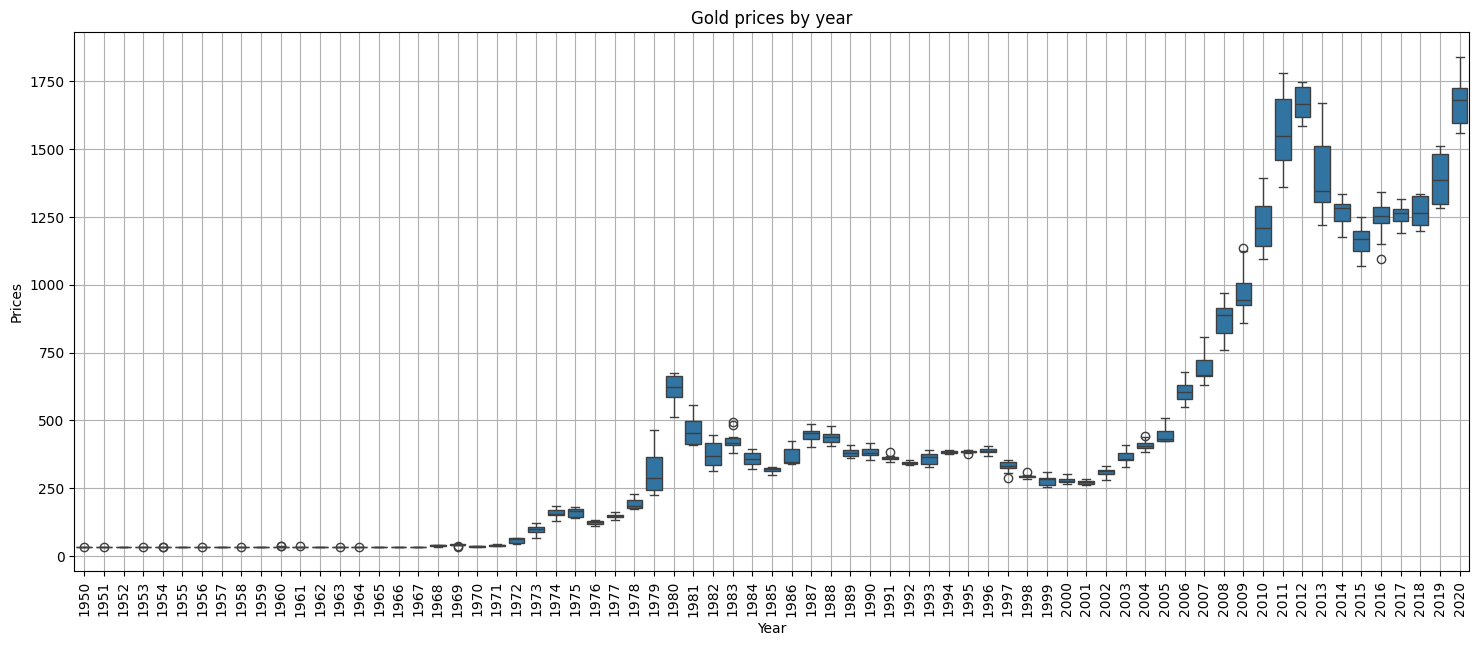

In [32]:
_, ax = plt.subplots(figsize = (18, 7))
sns.boxplot(x = df.index.year, y = df.values[:, 0], ax = ax)
plt.title('Gold prices by year')
plt.xlabel('Year')
plt.ylabel('Prices')
plt.xticks(rotation = 90)
plt.grid()

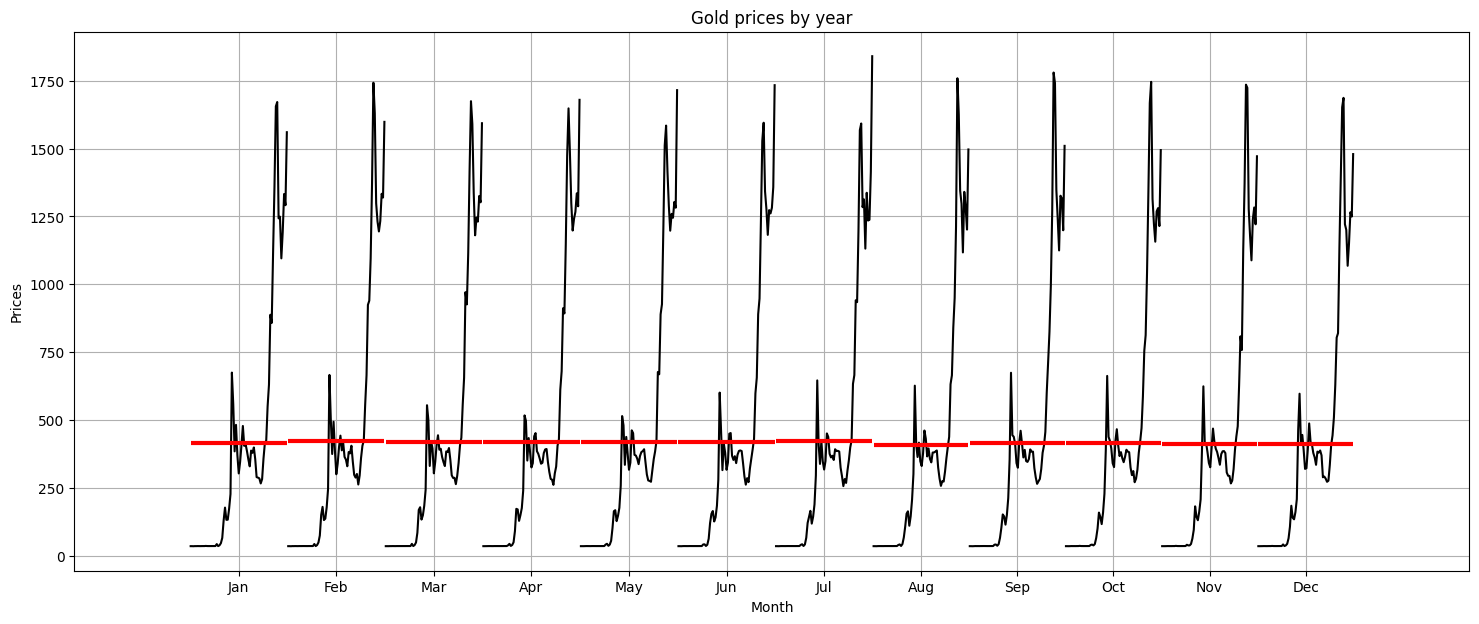

In [33]:
from statsmodels.graphics.tsaplots import month_plot

fig, ax = plt.subplots(figsize = (18, 7))
month_plot(df, ylabel = 'Gold Price', ax = ax)
plt.title('Gold prices by year')
plt.xlabel('Month')
plt.ylabel('Prices')
plt.grid()

## Plotting Gold prices by takign mean of Avg prices by year, quarter nd decade

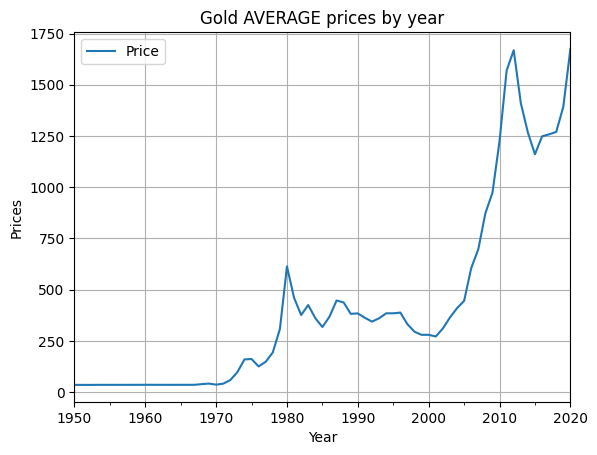

In [34]:
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot()
plt.title('Gold AVERAGE prices by year')
plt.xlabel('Year')
plt.ylabel('Prices')
plt.grid()

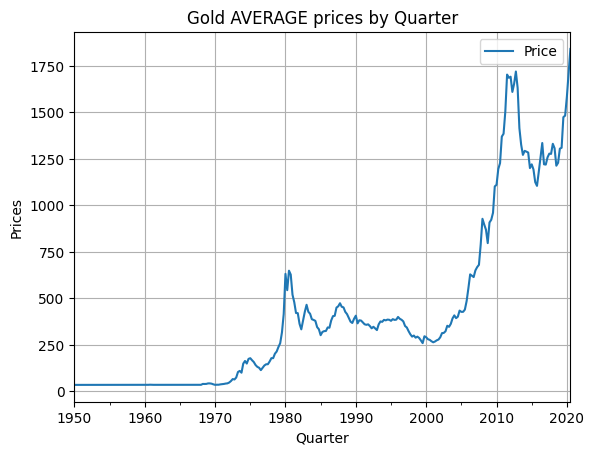

In [35]:
df_quarterly_sum = df.resample('Q').mean()
df_quarterly_sum.plot()
plt.title('Gold AVERAGE prices by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Prices')
plt.grid()

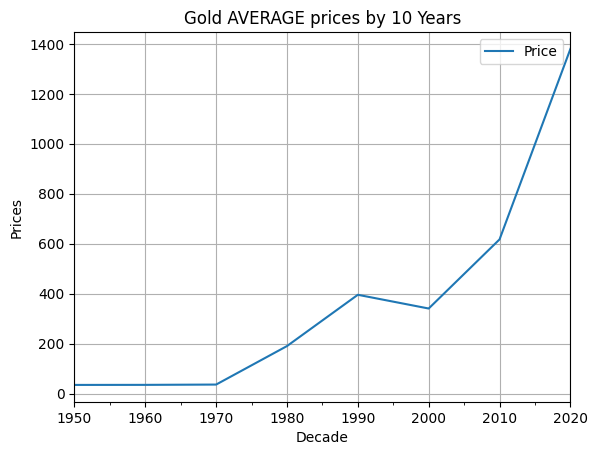

In [36]:
df_decade_sum = df.resample('10Y').mean()
df_decade_sum.plot()
plt.title('Gold AVERAGE prices by 10 Years')
plt.xlabel('Decade')
plt.ylabel('Prices')
plt.grid()

### Coefficient of Variation

**Coefficient of Variation (CV)**: A statistical measure that shows the extent of variability in relation to the mean of the data. It is calculated as the ratio of the standard deviation to the mean, often expressed as a percentage. CV is useful for comparing the degree of variation between different data sets, regardless of their units or mean values.


In [37]:
df_1 = df.groupby(df.index.year).mean().rename(columns = {'Price': 'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns = {'Price': 'Std'}), left_index = True, right_index = True)
df_1['Cov_pct'] = ((df_1['Std'] / df_1['Mean']) * 100).round(2)
df_1.head()

,Mean,Std,Cov_pct
Month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


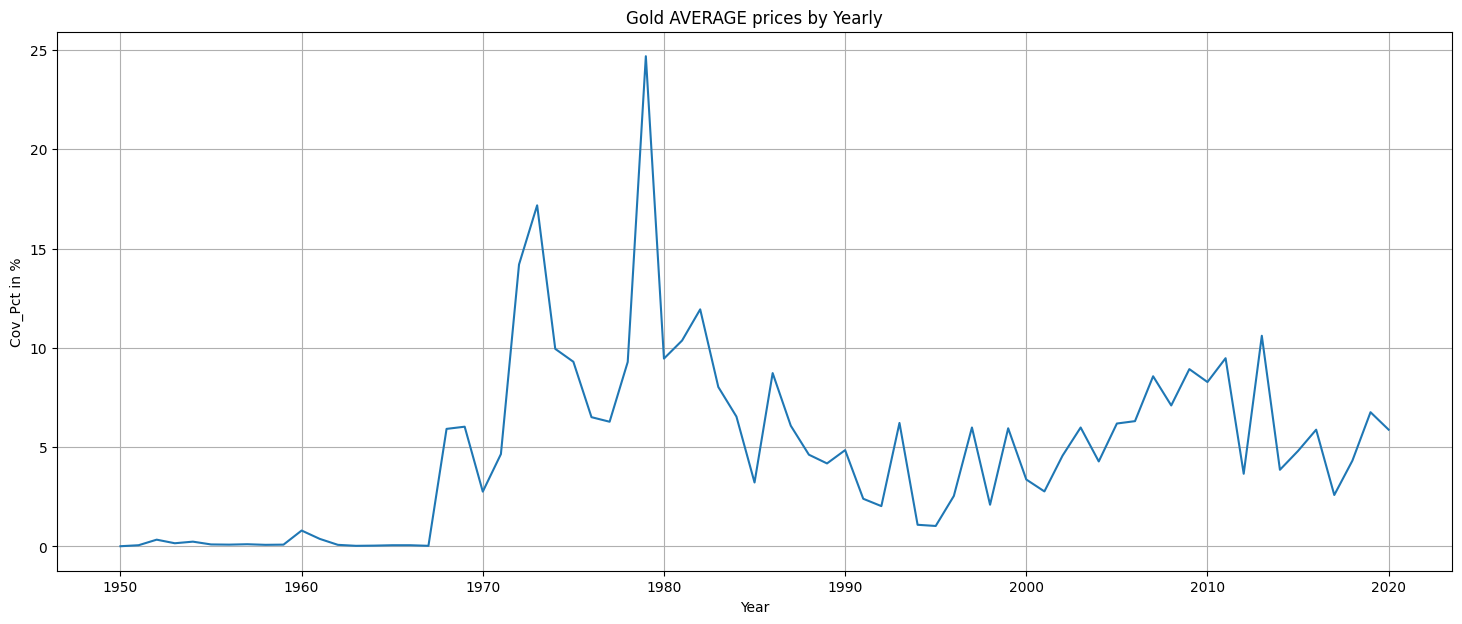

In [40]:
#Plotting Cov_pct Plots
fig, ax = plt.subplots(figsize = (18, 7))
df_1['Cov_pct'].plot()
plt.title('Gold AVERAGE prices by Yearly')
plt.xlabel('Year')
plt.ylabel('Cov_Pct in %')
plt.grid()

### Model Formation, Training, and Testing

**Model Formation**: The process of selecting and defining a machine learning model to fit the data. This includes choosing the type of model, such as linear regression or neural networks, and setting its parameters.

**Training**: The phase where the model is fed historical data to learn patterns and relationships. During training, the model adjusts its parameters to minimize prediction errors.

**Testing**: After training, the model is evaluated using a separate set of data (test data) that it has not seen before. This helps to assess the model's performance and its ability to generalize to new, unseen data.


In [43]:
train = df[df.index.year <= 2015]
test = df[df.index.year > 2015]
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


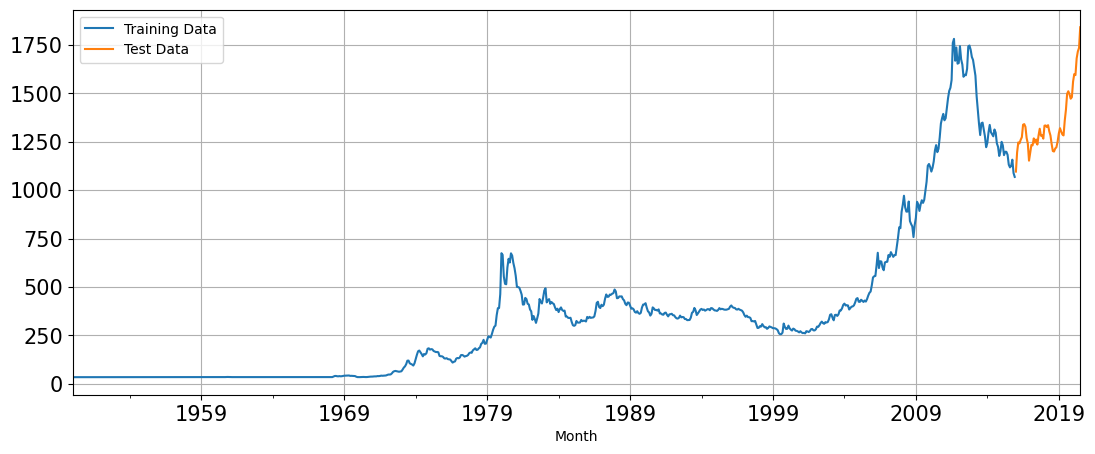

In [44]:
train['Price'].plot(figsize= (13, 5), fontsize=15)
test['Price'].plot(figsize= (13, 5), fontsize=15)
plt.grid()
plt.legend(['Training Data', 'Test Data'])
plt.show()

In [45]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(test)+1 for i in range(len(test))]
len(train_time), len(test_time)

(792, 55)

### Linear Regression Training

**Linear Regression Training**: This process involves teaching a linear regression model to find the relationship between input variables (features) and the target variable (output). The model learns by adjusting its parameters to minimize the difference between the predicted values and the actual values in the training data. This is typically done using methods like ordinary least squares to find the best-fitting line through the data points.


In [47]:
#Linear Reg Training LR
LR_train = train.copy()
LR_test = test.copy()
LR_train['time'] = train_time
LR_test['time'] = test_time

In [48]:
LR = LinearRegression()
LR.fit(LR_train[['time']], LR_train['Price'].values)

LinearRegression()

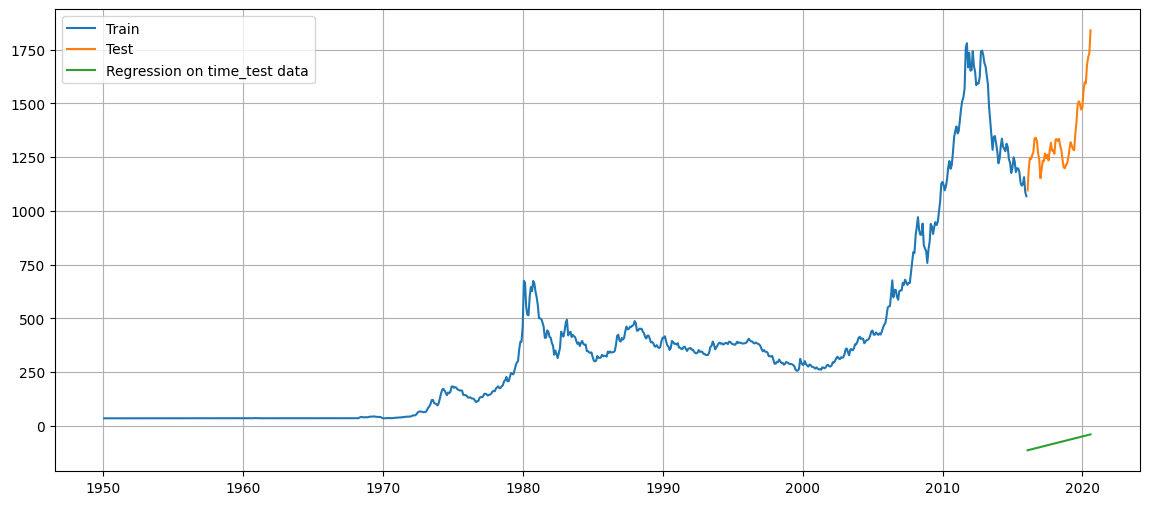

In [50]:
test_predictions_model1 = LR.predict(LR_test[['time']])
LR_test['Forecast'] = test_predictions_model1

plt.figure(figsize=(14, 6))
plt.plot(train['Price'], label = 'Train')
plt.plot(test['Price'], label = 'Test')
plt.plot(LR_test['Forecast'], label = 'Regression on time_test data')
plt.legend(loc = 'best')
plt.grid()

### Mean Absolute Percentage Error (MAPE)

**Mean Absolute Percentage Error (MAPE)**: MAPE is a measure of the accuracy of a forecasting method, expressed as a percentage. It calculates the average of the absolute percentage differences between the predicted and actual values. MAPE provides a standardized way to assess the performance of a forecasting model, making it useful for comparing different models or evaluating the overall accuracy of predictions.


In [55]:
def mape(actual, pred): return round((np.mean(abs(actual - pred)/ actual))*100, 2)

In [56]:
mape_model1_test = mape(test['Price'].values, test_predictions_model1)
print('Mape is %3.3f' % (mape_model1_test), '%')

Mape is 105.940 %


In [58]:
results = pd.DataFrame({'Test MAPE (%)' : [mape_model1_test]}, index = ['RegressionOnTime'])
results

,Test MAPE (%)
RegressionOnTime,105.94


In [59]:
final_model = ExponentialSmoothing(df, trend='additive', seasonal='additive').fit(smoothing_level=0.4,
                                                                                  smoothing_trend=0.3,
                                                                                  smoothing_seasonal=0.6)

In [61]:
Mape_final_model = mape(df['Price'].values, final_model.fittedvalues)
print('Mape is %3.2f' % (Mape_final_model), '%')

Mape is 17.24 %


In [63]:
predictions = final_model.forecast(steps = len(test))
predictions

2020-08-31    1792.871037
2020-09-30    1723.457050
2020-10-31    1646.718895
2020-11-30    1584.909572
2020-12-31    1567.478262
2021-01-31    1622.568574
2021-02-28    1653.503369
2021-03-31    1664.915350
2021-04-30    1756.460802
2021-05-31    1802.376887
2021-06-30    1851.553061
2021-07-31    1904.259324
2021-08-31    1893.188409
2021-09-30    1823.774422
2021-10-31    1747.036267
2021-11-30    1685.226944
2021-12-31    1667.795634
2022-01-31    1722.885946
2022-02-28    1753.820741
2022-03-31    1765.232722
2022-04-30    1856.778174
2022-05-31    1902.694259
2022-06-30    1951.870433
2022-07-31    2004.576696
2022-08-31    1993.505781
2022-09-30    1924.091794
2022-10-31    1847.353639
2022-11-30    1785.544316
2022-12-31    1768.113006
2023-01-31    1823.203318
2023-02-28    1854.138113
2023-03-31    1865.550094
2023-04-30    1957.095545
2023-05-31    2003.011631
2023-06-30    2052.187805
2023-07-31    2104.894068
2023-08-31    2093.823153
2023-09-30    2024.409165
2023-10-31  

## Final DF Using Final Model

In [65]:
predicted_df = pd.DataFrame({'Lower_CI' : predictions - 1.96 * np.std(final_model.resid, ddof=1),
                             'Prediction': predictions,
                             'Upper_CI': predictions + 1.96 * np.std(final_model.resid, ddof=1)})
predicted_df.head()

,Lower_CI,Prediction,Upper_CI
2020-08-31,1684.720065,1792.871037,1901.022009
2020-09-30,1615.306077,1723.457050,1831.608022
2020-10-31,1538.567922,1646.718895,1754.869867
2020-11-30,1476.758600,1584.909572,1693.060545
2020-12-31,1459.327290,1567.478262,1675.629235


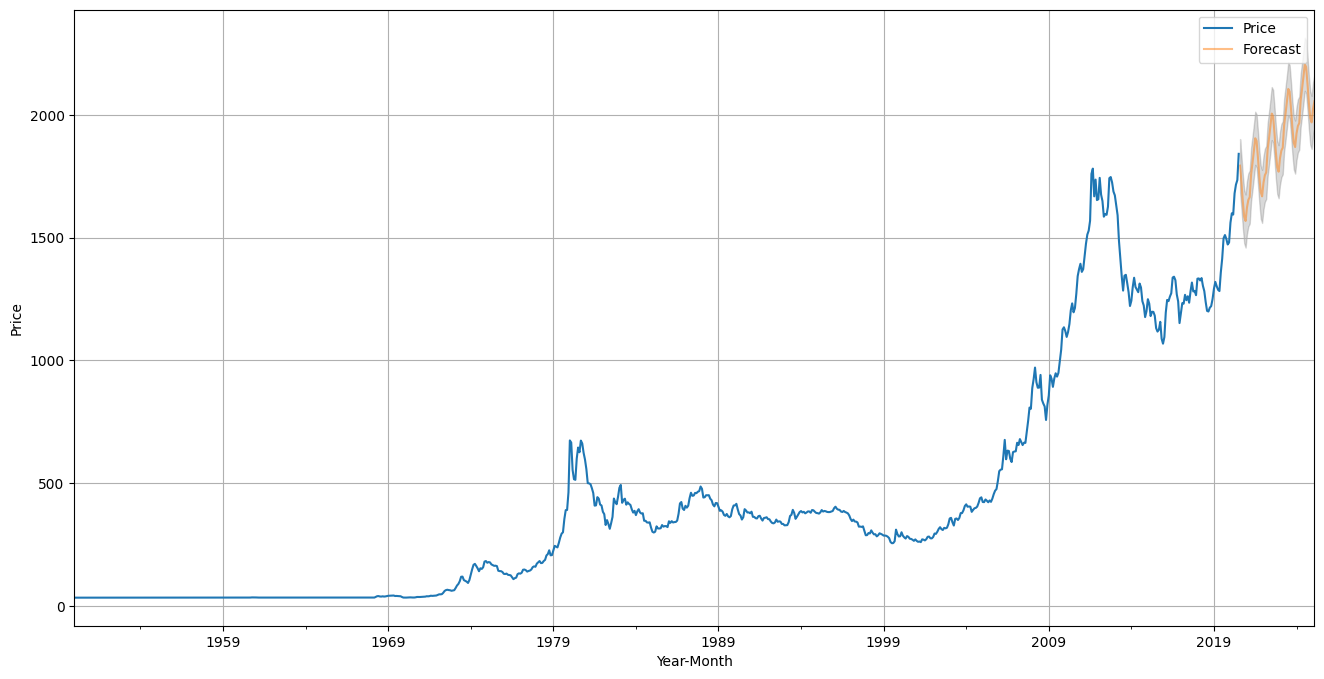

In [66]:
axis = df.plot(label = 'Actual', figsize = (16, 8))
predicted_df['Prediction'].plot(ax = axis, label = 'Forecast', alpha = 0.5)
axis.fill_between(predicted_df.index, predicted_df['Lower_CI'], predicted_df['Upper_CI'], color = 'k', alpha = 0.15)
axis.set_xlabel('Year-Month')
axis.set_ylabel('Price')
plt.legend(loc = 'best')
plt.grid()

## Here in following SS you can see that as per above analysis the predicted prices forming channel, & Here in SS also the actual price of Gold showing channel. After 2020 it goes down and again raising in 2023-24.

## The next predicted move is for taking rejection from resistance trendline and make a deep.

![image](https://github.com/prasad-chavan1/doyouwannagooutwithme/blob/main/Screenshot%202024-06-15%20094031.png?raw=true)
